In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/made-recsys/tracks.npy
/kaggle/input/made-recsys/tracks.json
/kaggle/input/made-recsys/data_preprocessed.csv
/kaggle/input/made-recsys/users.json
/kaggle/input/made-recsys/data/data/data.json.1
/kaggle/input/made-recsys/data/data/data.json
/kaggle/input/made-recsys/data/data/data.json.7
/kaggle/input/made-recsys/data/data/data.json.4
/kaggle/input/made-recsys/data/data/data.json.5
/kaggle/input/made-recsys/data/data/data.json.2
/kaggle/input/made-recsys/data/data/data.json.3
/kaggle/input/made-recsys/data/data/data.json.6
/kaggle/input/made-recsys/data/data/data.json.10
/kaggle/input/made-recsys/data/data/data.json.9
/kaggle/input/made-recsys/data/data/data.json.8


In [2]:
!pip install -q pytorch_lightning
!pip install -q tensorboardX

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.83.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.1 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.1 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.20.1 which is incompatible.
grpc-google-iam-v1 0.12.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you h

In [3]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb
import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import gc

np.random.seed(31337)

# Preprocess Dataset

In [ ]:
# Read sessions jsons
dfs = []
root_path = "/kaggle/input/made-recsys/data/data/data.json."
df = pd.read_json(root_path[:-1], lines=True)
dfs.append(df)
for i in range(1, 11):
    df = pd.read_json(root_path + str(i), lines=True)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

In [6]:
# Sort for correct sequence and drop useless features
df.sort_values(["user", "timestamp"], inplace=True, ignore_index=True)
df.drop(columns=["timestamp", "latency", "recommendation", "experiments"], inplace=True)
gc.collect()

23

In [17]:
# Read tracks data
tracks_df = pd.read_json("/kaggle/input/made-recsys/tracks.json", lines=True)
tracks_df.drop(columns=["title"], inplace=True)
tracks_df["artist"] = tracks_df.artist.apply(lambda artists: artists.split('/')[0].lower().strip())

In [12]:
# Add artist feature to main dataframe
df = df.join(tracks_df.set_index("track"), on="track")

In [37]:
# Make each row to contain current and next track info
df_shifted = df[1:].copy()
df_shifted = df_shifted.append({"message": "next", "user": 555555, "track": 555555, "time": 0.00, "artist": "ogbuda"}, ignore_index=True)
df_shifted = df_shifted.add_prefix("next_")

df = pd.concat([df, df_shifted], axis="columns")
df.drop(df[df.message == 'last'].index, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [58]:
# Save preprocessed data
df.to_csv("data_preprocessed.csv", index=False)

# Train model

**The model input** is six: 
user_id, current_track_id, current_track_artist, current_track_listening_time, next_track, next_track_artist  
**The model output** is predicted next_track_listening_time.  
**Loss**: MSE

**Model described by following formula**:
$$t_{next\_track} = sigmoid(\mu + b_u + b_{next\_track} + (h_{next\_track} + h_{next\_artist})^T(h_u + h_{curr\_track} + h_{curr\_artist} + h_{curr\_time})), h - embedding.$$  

Based on predicted tracks listening times tracks will be sorted and returns top k.

**Main hypothesis(experiment idea)**: as we added more information to the model(individual embeddings for user, tracks artists and current track listening time), we expect metrics growth.

In [4]:
# Load dataset
df = pd.read_csv("/kaggle/input/made-recsys/data_preprocessed.csv")

In [5]:
# Encode artists and times(consider only 0.00, 0.01, ..., 0.98, 0.99, 1.00 values as labels)
le_artist = LabelEncoder()
le_artist.fit(df.artist)
le_time = LabelEncoder()
le_time.fit(df.time)
df["time"] = le_time.transform(df["time"])
df["artist"] = le_artist.transform(df["artist"])
df["next_artist"] = le_artist.transform(df["next_artist"])

In [6]:
rdm = np.random.random(len(df))
train_data = df[rdm < 0.8]
val_data = df[(rdm >= 0.8) & (rdm < 0.9)]
test_data = df[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(4033662, 503993, 504630)

In [8]:
class CustomSVD(pl.LightningModule):
    def __init__(self, embedding_dim=10, num_users=10000, num_tracks=50000, num_artists=10685, num_times=101):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        self.user_embeddings = nn.Embedding(num_embeddings=num_users, embedding_dim=self.embedding_dim)
        self.track_embeddings = nn.Embedding(num_embeddings=num_tracks, embedding_dim=self.embedding_dim)
        self.artist_embeddings = nn.Embedding(num_embeddings=num_artists, embedding_dim=self.embedding_dim)
        self.time_embeddings = nn.Embedding(num_embeddings=num_times, embedding_dim=self.embedding_dim)
        self.user_bias = nn.Embedding(num_embeddings=num_users, embedding_dim=1)
        self.track_bias = nn.Embedding(num_embeddings=num_tracks, embedding_dim=1)
        self.mu = nn.Parameter(torch.tensor(0.))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        user = self.user_embeddings(x[:, 0].squeeze(0))
        track = self.track_embeddings(x[:, 1].squeeze(0))
        track_artist = self.artist_embeddings(x[:, 2].squeeze(0))
        track_time = self.time_embeddings(x[:, 3].squeeze(0))
        next_track = self.track_embeddings(x[:, 4].squeeze(0))
        next_track_artist = self.artist_embeddings(x[:, 5].squeeze(0))
        user_bias = self.user_bias(x[:, 0].squeeze(0))
        next_track_bias = self.track_bias(x[:, 4].squeeze(0))
        
        user_final = user + track + track_artist + track_time
        next_track_final = next_track + next_track_artist
        score = torch.sum(user_final * next_track_final, dim=1).unsqueeze(1) + user_bias + next_track_bias + self.mu
        return self.sigmoid(score)
            
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        targets = y[:, 0].float()
        avgs = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [9]:
class ContextualRankerData(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, features, target, batch_size=2048):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.features = features
        self.target = target
        self.batch_size = batch_size

    def prepare_data(self):
        self.test_data = self.test_data.assign(rdm = np.random.random(len(self.test_data))).assign(avg = self.train_data[self.target].mean())

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = td.TensorDataset(
                torch.from_numpy(self.train_data[self.features].values), 
                torch.from_numpy(self.train_data[self.target].values)
            )

            self.val_dataset = td.TensorDataset(
                torch.from_numpy(self.val_data[self.features].values), 
                torch.from_numpy(self.val_data[self.target].values)
            )

        if stage == "test" or stage is None:  
            self.test_dataset = td.TensorDataset(
                torch.from_numpy(self.test_data[self.features].values),
                torch.from_numpy(self.test_data[[*self.target, "avg", "rdm"]].values)
            )
    def train_dataloader(self):
        return td.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return td.DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=0)

    def test_dataloader(self):
        return td.DataLoader(self.test_dataset, batch_size=512, shuffle=False, num_workers=0)

In [10]:
embedding_dim = 100
num_users = df.user.unique().shape[0]
num_tracks = df.track.unique().shape[0]
num_artists = df.artist.unique().shape[0]
num_times = df.time.unique().shape[0]

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [12]:
wandb_logger = WandbLogger(project='made-recsys-hw')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [13]:
net = CustomSVD(embedding_dim=embedding_dim,
                num_users=num_users, 
                num_tracks=num_tracks, 
                num_artists=num_artists, 
                num_times=num_times)
data_module = ContextualRankerData(train_data, val_data, test_data, 
                                   features = ["user", "track", "artist", "time", "next_track", "next_artist"], 
                                   target=["next_time"])

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=10,
    accelerator='gpu', 
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback,
    ], 
    logger=wandb_logger)

In [14]:
trainer.fit(
    net, 
    data_module
)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [15]:
best = CustomSVD.load_from_checkpoint(checkpoint_callback.best_model_path, 
                                      embedding_dim=embedding_dim,
                                      num_users=num_users, 
                                      num_tracks=num_tracks, 
                                      num_artists=num_artists,
                                      num_times=num_times)

In [16]:
trainer.validate(best, data_module)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.10828045755624771    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.10828045755624771}]

In [35]:
user_embeddings = best.user_embeddings.weight.detach().numpy()
track_embeddings = best.track_embeddings.weight.detach().numpy()
artist_embeddings = best.artist_embeddings.weight.detach().numpy()
time_embeddings = best.time_embeddings.weight.detach().numpy()
user_bias = best.user_bias.weight.detach().numpy()
track_bias = best.track_bias.weight.detach().numpy()
mu = best.mu.detach().numpy()

In [36]:
# Precalculate track_embs and artist_embs sum
tracks_df["le_artist"] = le_artist.transform(tracks_df.artist)
track_embeddings = track_embeddings + artist_embeddings[tracks_df.le_artist]

In [62]:
# Save embeddings (dont forget move them to botify/data)
with open("embeddings.npz", "wb") as f:
    np.savez(f, 
             user_embeddings=user_embeddings,
             track_embeddings=track_embeddings,
             #artist_embeddings = best.artist_embeddings.weight.detach().numpy(),
             time_embeddings=time_embeddings,
             user_bias=user_bias,
             track_bias=track_bias,
             mu=mu,
    )

# Test model

In [1]:
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

pd.set_option("display.precision", 3)

%matplotlib inline

In [2]:
experiment = "PERSONALIZED"
experiment = "RECOMMENDERS"
experiment = "CONTEXTUAL"
experiment = "CUSTOM_SVD"

In [3]:
data = pd.read_json("/tmp/recsys/data.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

In [4]:
data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments,treatment
0,next,2023-04-14 20:50:05.413,3255,2659,1.00,5.569e-04,789.0,{'CUSTOM_SVD': 'C'},C
1,next,2023-04-14 20:50:05.418,3255,789,1.00,5.820e-04,1917.0,{'CUSTOM_SVD': 'C'},C
2,next,2023-04-14 20:50:05.422,3255,1917,0.79,4.387e-04,2251.0,{'CUSTOM_SVD': 'C'},C
3,next,2023-04-14 20:50:05.426,3255,2251,1.00,4.125e-04,3090.0,{'CUSTOM_SVD': 'C'},C
4,next,2023-04-14 20:50:05.429,3255,3090,0.49,4.220e-04,1594.0,{'CUSTOM_SVD': 'C'},C


## Visualize sessions

In [5]:
Session = namedtuple("Session", ["timestamp", "tracks", "time", "latency"])

def sessionize(user_data):
    sessions = []
    session = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if session is None:
            session = Session(row["timestamp"], 0, 0, 0)
        
        session = session._replace(
            tracks = session.tracks + 1, 
            time = session.time + row["time"],
            latency = session.latency + row["latency"] * 1000,
        )
        
        if row["message"] == "last":
            sessions.append(session._asdict())
            session = None
    return sessions

In [6]:
sessions = (
    data
    .groupby(["user", "treatment"])
    .apply(sessionize)
    .explode()
    .apply(pd.Series)
)

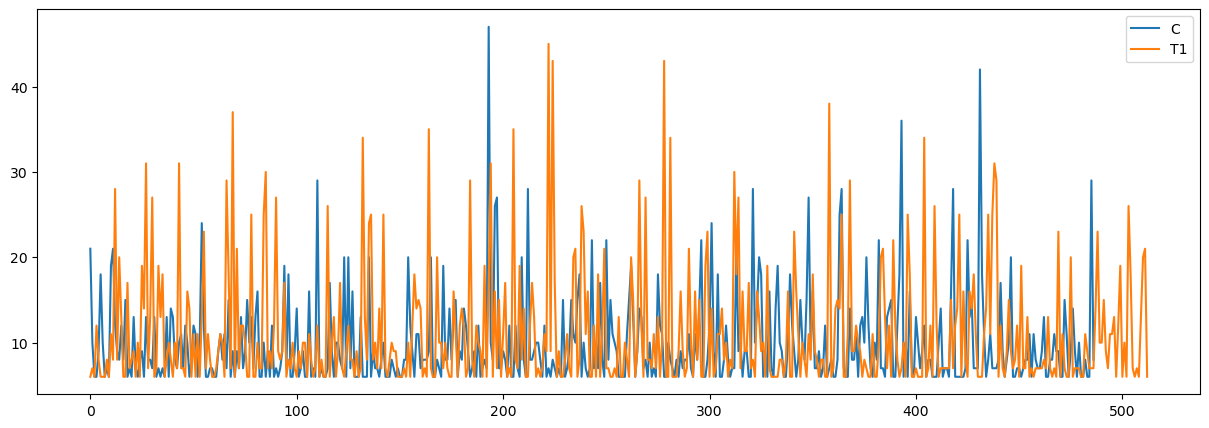

In [7]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["tracks"], label=treatment)
ax.legend()
pass

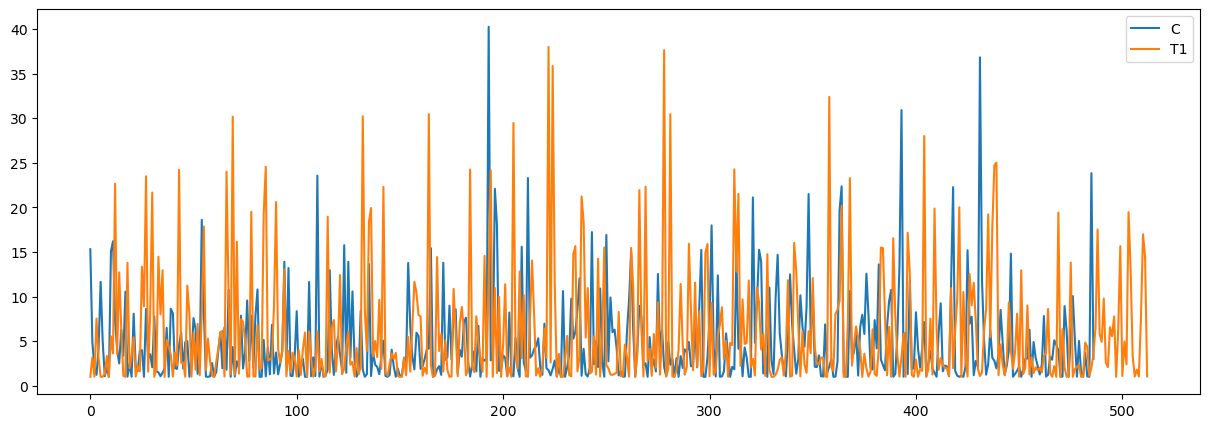

In [8]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["time"], label=treatment)
ax.legend()
pass

## Analyze the experiment

In [9]:
user_level_data = (
  sessions
    .reset_index()
    .groupby(["user", "treatment"])
    .agg(
        {
            "timestamp": "count",
            "tracks": "sum",
            "time": "sum",
            "latency": "sum"
        }
    )
)

user_level_data["sessions"] = user_level_data["timestamp"]
user_level_data["mean_request_latency"] = user_level_data["latency"] / user_level_data["tracks"]
user_level_data["mean_tracks_per_session"] = user_level_data["tracks"] / user_level_data["sessions"]
user_level_data["mean_time_per_session"] = user_level_data["time"] / user_level_data["sessions"]

metrics = [
    #"time", 
    #"sessions", 
    #"mean_request_latency", 
    #"mean_tracks_per_session", 
    "mean_time_per_session"
]

user_level_metrics = user_level_data[metrics].copy().reset_index()

In [10]:
treatment_level_metrics = (
    user_level_metrics
    .groupby("treatment")[metrics]
    .agg(["count", "mean", "var"])
)

In [11]:
def dof(n_0, n_1, s2_0, s2_1):
    numerator = (s2_0 / n_0 + s2_1 / n_1) * (s2_0 / n_0 + s2_1 / n_1)
    denominator = s2_0 * s2_0 / n_0 / n_0 / (n_0 - 1) + s2_1 * s2_1 / n_1 / n_1 / (n_1 - 1)
    return numerator / denominator


def ci(n_0, n_1, s2_0, s2_1, alpha=0.05):
    return ss.t.ppf(1 - alpha/2, dof(n_0, n_1, s2_0, s2_1)) * np.sqrt(s2_0 / n_0 + s2_1 / n_1)


effects = []

control = [data for treatment, data in treatment_level_metrics.iterrows() if treatment == "C"][0]

for treatment, row in treatment_level_metrics.iterrows():
    if treatment == "C":
        continue
    
    for metric in metrics:
        control_mean = control[metric]["mean"]
        treatment_mean = row[metric]["mean"]
        
        effect = treatment_mean - control_mean
        conf_int = ci(
            control[metric]["count"],
            row[metric]["count"],
            control[metric]["var"],
            row[metric]["var"],
        )
        effects.append({
            "treatment": treatment,
            "metric": metric,
            "control_mean": control_mean,
            "treatment_mean": treatment_mean,
            "effect": effect / control_mean * 100,
            "lower": (effect - conf_int) / control_mean * 100,
            "upper": (effect + conf_int) / control_mean * 100,
            "significant": (effect + conf_int) * (effect - conf_int) > 0
        })

In [12]:
def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,mean_time_per_session,26.038539,41.756545,10.320533,4.837079,6.096584,True


**Conclusion:**
Indeed, proposed model with more information usage show significantly better results.